In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Research/qnumerics/QNumerics2025_Control/lecture-3`
    Updating registry at `~/.julia/registries/General.toml`
   Installed SciMLOperators ────────── v0.4.0
   Installed IncompleteLU ──────────── v0.2.1
   Installed DiffEqBase ────────────── v6.176.0
   Installed QuantumToolbox ────────── v0.32.1
   Installed AbstractDifferentiation ─ v0.6.2
   Installed SciMLBase ─────────────── v2.99.0
    Updating `~/Research/qnumerics/QNumerics2025_Control/lecture-3/Project.toml`
⌃ [13f3f980] + CairoMakie v0.13.10
  [c4671d76] + Piccolo v0.8.0
  [6c2fb7c5] + QuantumToolbox v0.32.1
  [295af30f] + Revise v3.8.0
    Updating `~/Research/qnumerics/QNumerics2025_Control/lecture-3/Manifest.toml`
  [47edcb42] + ADTypes v1.15.0
  [c29ec348] + AbstractDifferentiation v0.6.2
  [621f4979] + AbstractFFTs v1.5.0
  [1520ce14] + AbstractTrees v0.4.5
  [7d9f7c33] + Accessors v0.1.42
  [79e6a3ab] + Adapt v4.3.0
  [35492f91] + AdaptivePredicates v1.2.0
  [66dad0bd] + AliasTables v1.1.3
  

In [2]:
using Piccolo
using LinearAlgebra
using CairoMakie
using QuantumToolbox
using SparseArrays

const ⊗ = kron

kron (generic function with 54 methods)

# I. Rotations
-----

## Goals
- Geodesics
- Controllability of LTI systems
- Dynamical Lie algebras and reachability

_Comparing initialization and optimization when restricted to a feasible manifold, and how warm starts are enabled by direct control._

![Initialization comparison between direct and indirect optimization.](../assets/fig2_feas-manifold.png)

In [3]:
U_goal = PAULIS.X
T = 50
Δt = 0.2

# U_goal = exp(-im * H_eff * T * Δt)
H_eff = im * log(U_goal / T / Δt)

2×2 Matrix{ComplexF64}:
 -1.5708-2.30259im   1.5708+0.0im
  1.5708+0.0im      -1.5708-2.30259im

In [4]:
# Draw the geodesic.

**Exercise**
- What happens if there is a drift operator? $H(t) = \Delta \omega Z + u(t) X$.
- Bonus: What about for an _Embedded operator_?

## Controllability

- Quick check: What happens when we kick a system $x_{n+1} = A x_n + B u_n$?

\begin{equation}
\mathcal{C} = \begin{bmatrix}
    B & A B & A^2 B & \cdots & A^{n-1} B
\end{bmatrix}
\end{equation}

- Quick check: Why did we stop at $n-1$?

**Example**
- Test on a linear system in 2D. Recall our $F = ma$ system.

In [5]:
function continuous_to_discrete(A, B, h)
    # Construct augmented matrix for matrix exponential
    augmented_matrix = [
        A B; 
        zeros(size(B, 2), size(A, 1)) zeros(size(B, 2), size(B, 2))
    ]

    # Compute matrix exponential
    exp_matrix = exp(augmented_matrix * h)

    # Extract discrete LTI system matrices
    A_h = exp_matrix[1:size(A, 1), 1:size(A, 2)]
    B_h = exp_matrix[1:size(A, 1), size(A, 2)+1:end]

    return A_h, B_h
end

# Extract discrete LTI system matrices
A_cts = [0.0 1.0; -1.0 -0.1]
B_cts = [0.0; 1.0]
h = 0.1  # Time step
A, B = continuous_to_discrete(A_cts, B_cts, h)

([0.9950207737420776 0.09933590957864684; -0.09933590957864684 0.9850871827842128], [0.004979226257922404; 0.09933590957864684;;])

- Let's create a 2D state.
\begin{equation}
    z = \begin{bmatrix} x \\ \dot{x} \\ y \\ \dot{y} \end{bmatrix}
\end{equation}

In [6]:
Axy = I(2) ⊗ A
Bxy = [B zeros(2); zeros(2) B]

C = hcat([Axy^n * Bxy for n in 0:size(Axy, 1)-1]...)

4×8 Matrix{Float64}:
 0.00497923  0.0         0.0148221  …  0.0        0.0336788  0.0
 0.0993359   0.0         0.0973599     0.0        0.0906016  0.0
 0.0         0.00497923  0.0           0.0244196  0.0        0.0336788
 0.0         0.0993359   0.0           0.0944356  0.0        0.0906016

In [7]:
rank(C)

4

In [8]:
Axy = I(2) ⊗ A

# Directly move the X particle only
Bxy = [[1; 0] zeros(2); [0; 1] zeros(2)]

C = hcat([Axy^n * Bxy for n in 0:size(Axy, 1)-1]...)

4×8 Matrix{Float64}:
 1.0  0.0   0.995021   0.0   0.980199  0.0   0.955779  0.0
 0.0  0.0  -0.0993359  0.0  -0.196696  0.0  -0.291131  0.0
 0.0  0.0   0.0993359  0.0   0.196696  0.0   0.291131  0.0
 1.0  0.0   0.985087   0.0   0.960529  0.0   0.926666  0.0

In [9]:
rank(C)

2

What about quantum systems? They are nonlinear.

- BCH
\begin{equation}
    e^{X} e^{Y} = e^{X + Y + \tfrac{1}{2} [X, Y] + \tfrac{1}{12} ([X, [X, Y]] + [Y, [Y, X]])} 
\end{equation}

- Collect commutators, forming the **Dynamical Lie algebra**.

- Quick check: How can we test for linear dependence?

In [36]:
# Linearly dependent: QR decomposition has a zero on diagonal 
# H_drives = [PAULIS.X, PAULIS.Y]
H_drives = [PAULIS.X, PAULIS.X]

M = stack(vec.(H_drives))
qr(M).R

2×2 Matrix{ComplexF64}:
 -1.41421+0.0im      -1.41421+0.0im
      0.0+0.0im  -3.14018e-16+0.0im

- Quick check: What about systems with drift?

# II. Demos
-----

**Bloch sphere**

In [37]:
Δ = 0.2
qubit = QuantumSystem(Δ * PAULIS.Z, [PAULIS.X, PAULIS.Y])
ψ0 = ket_from_string("e+g", [2])
ψT = ket_from_bitstring("0")
T = 50
Δt = 0.2
prob = QuantumStateSmoothPulseProblem(qubit, ψ0, ψT, T, Δt)

    constructing QuantumStateSmoothPulseProblem...
	using integrator: typeof(KetIntegrator)
	using 1 initial state(s)
	applying timesteps_all_equal constraint: Δt


DirectTrajOptProblem
   timesteps            = 50
   duration             = 9.799999999999997
   variable names       = (:ψ̃, :a, :da, :dda, :Δt)
   knot point dimension = 11


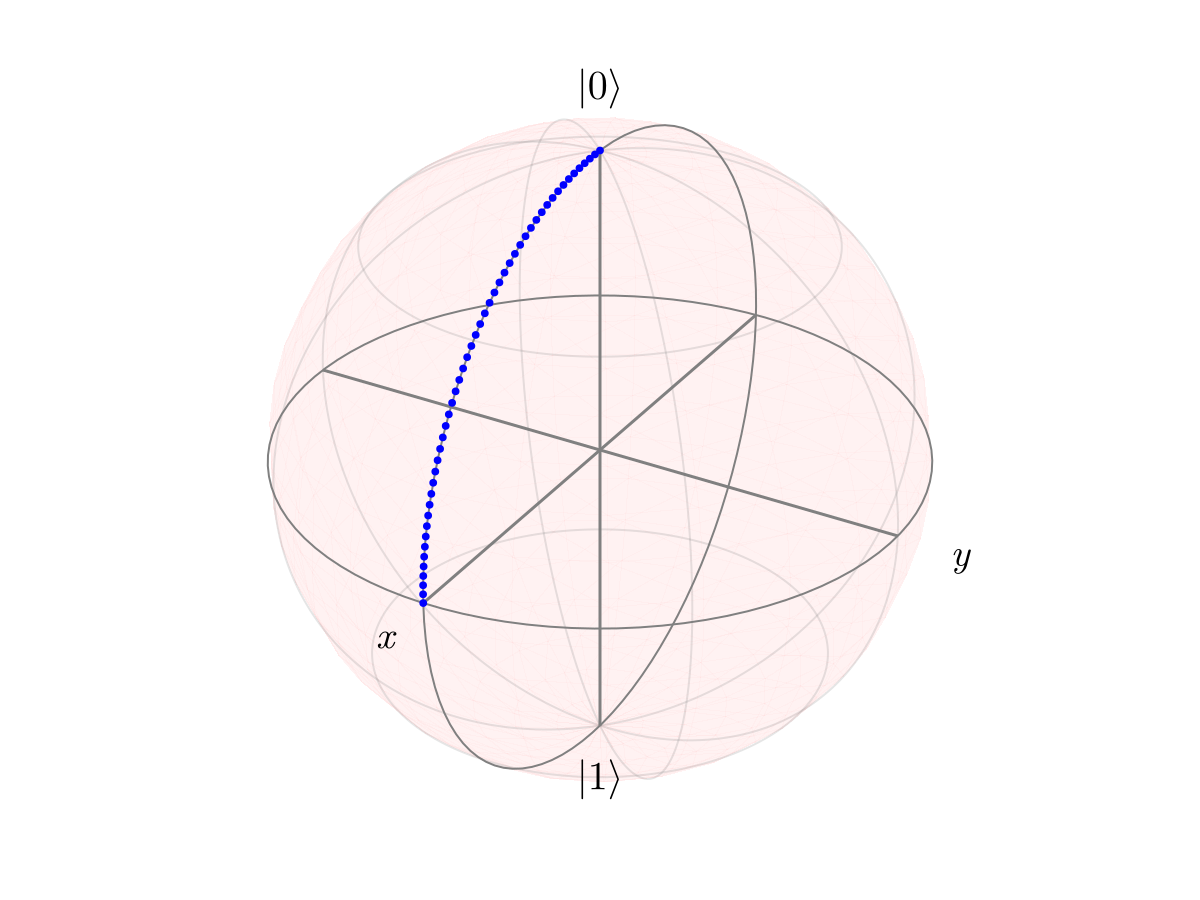

In [38]:
fig, = plot_bloch(prob.trajectory)
fig

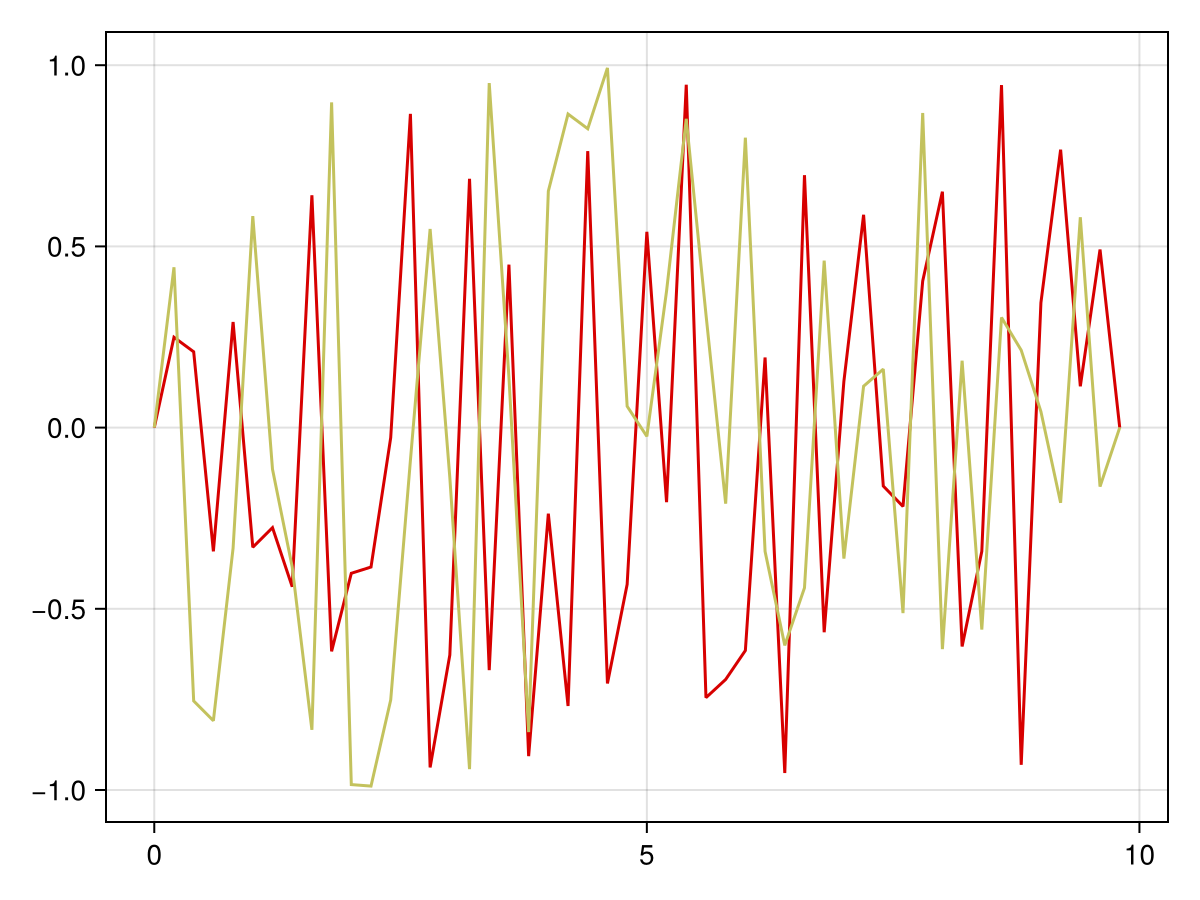

In [39]:
plot(prob.trajectory, :a)

In [40]:
solve!(prob, max_iter=100, options=IpoptOptions(eval_hessian=true))

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of ψ̃
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:     2422
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2115

Total number of variables............................:      542
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      246
                     variables with only upper bounds:        0
Total number of equality constraints.................:      441
Total number o

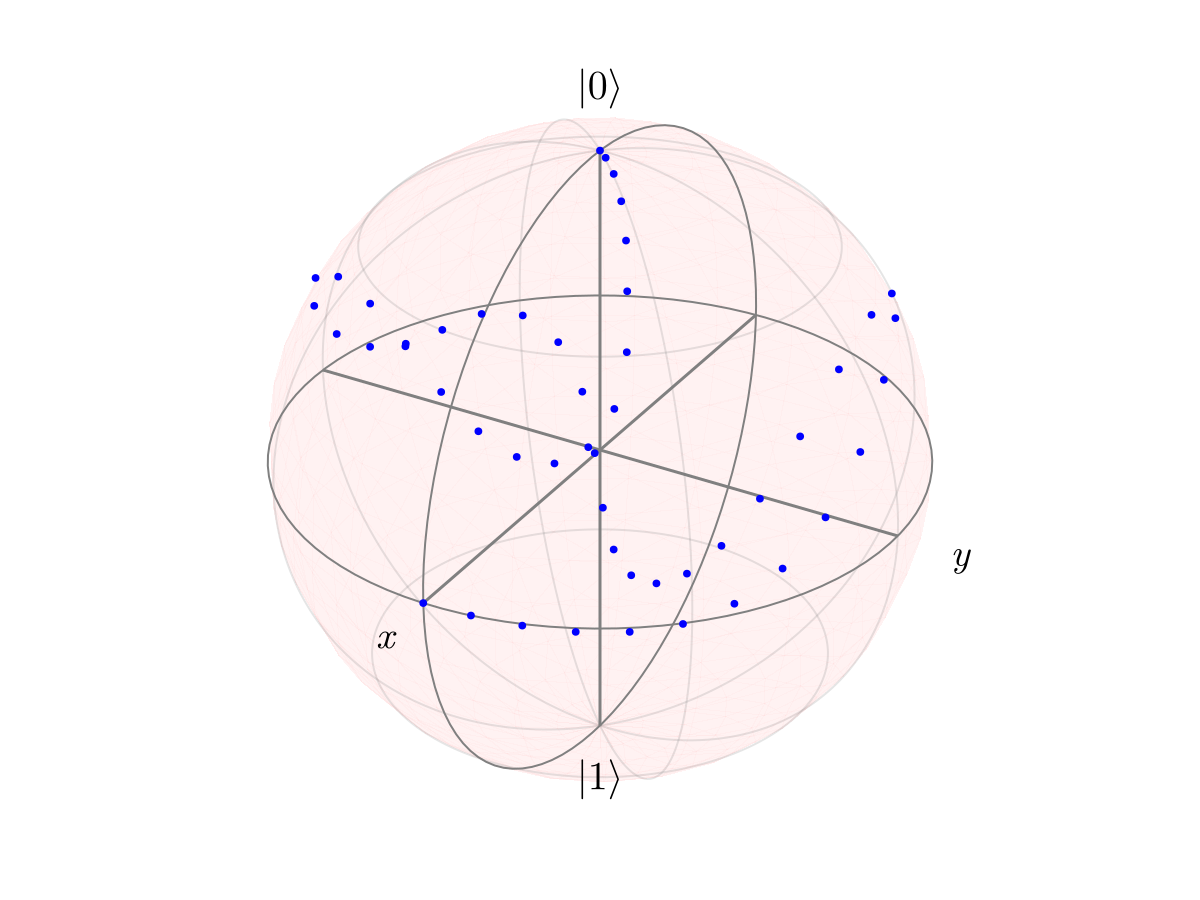

In [41]:
fig, = plot_bloch(prob.trajectory)
fig

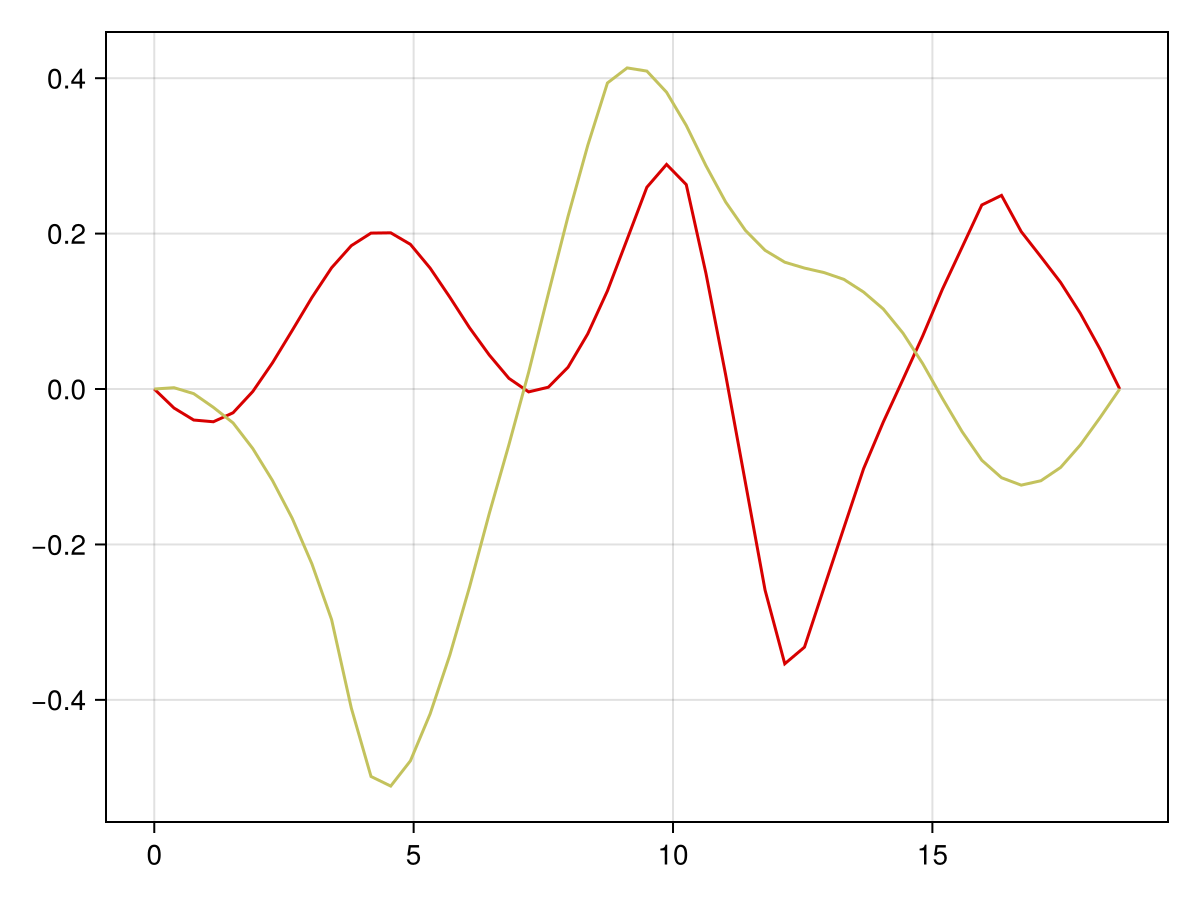

In [42]:
plot(prob.trajectory, :a)

**CZ gate**

\begin{equation}
    H(t) = \sum_j \tfrac{\eta}{2} a_j^\dagger a_j^\dagger a_j a_j + \Delta(t) (a_1^\dagger a_1) + g(t) (a_1^\dagger a_2 + a_1 a_2^\dagger)
\end{equation} 

In [43]:
n_levels = 2
a = lift_operator(annihilate(n_levels), 1, 2)
b = lift_operator(annihilate(n_levels), 2, 2)
η = -0.3

H_drift = η/2 * (a'a'*a*a + b'b'*b*b)
H_drives = [a'a', (a'b + a*b')]
transmons = QuantumSystem(H_drift, H_drives)

U_goal = EmbeddedOperator(
    GATES.CZ, 
    get_subspace_indices([1:2, 1:2], [n_levels, n_levels]), 
    [n_levels, n_levels]
)

EmbeddedOperator{ComplexF64}(ComplexF64[1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im -1.0 + 0.0im], [1, 2, 3, 4], [2, 2])

In [44]:
commutator(A, B) = A * B - B * A

commutator (generic function with 1 method)

In [45]:
A = H_drives[1]
B = H_drives[2]
commutator(A, B) |> sparse

4×4 SparseMatrixCSC{ComplexF64, Int64} with 0 stored entries:
     ⋅          ⋅          ⋅          ⋅    
     ⋅          ⋅          ⋅          ⋅    
     ⋅          ⋅          ⋅          ⋅    
     ⋅          ⋅          ⋅          ⋅    

In [61]:
is_reachable(U_goal, transmons)

operator algebra depth = [1]


ArgumentError: ArgumentError: `stack` on an empty collection is not allowed

**Continous-variable quantum computing**

\begin{equation}
    H(t) = \Omega(t) a^\dagger + \Omega(t) a + \kappa(t) a^2 + \kappa^*(t) (a^\dagger)^2
\end{equation}

In [90]:
n_levels = 5

a = annihilate(n_levels)
X = a + a'
Y = -im * (a - a')
X2 = a^2 + (a')^2
Y2 = -im * (a^2 - (a')^2)

Ω = 1.0
κ = 0.1

sys = QuantumSystem([X, Y, X2, Y2])

# Displacement and squeezing operators
function displacement(α)
    return exp(α * a' - conj(α) * a)
end

function squeezing(r)
    return exp((r / 2) * (a^2 - (a')^2))
end

# Initial states
ψ0 = I(n_levels)[:, 1] .+ 0.0im
ψα = displacement(im * 1.5) * ψ0;
ψs = squeezing(0.5) * displacement(0.5 + 0.5im) * ψ0;
ψs

5-element Vector{ComplexF64}:
   0.7274368279485289 + 0.08379539462600397im
   0.2732317136965428 + 0.36403586011179717im
 -0.26906111979151676 + 0.1634807537631869im
  -0.2884595663616072 - 0.15919291236653724im
  0.08267502401506288 - 0.20525595962886536im

## Coherent state

In [48]:
T = 50
Δt = 0.4
prob = QuantumStateSmoothPulseProblem(sys, ψ0, ψα, T, Δt, dda_bound=0.1)
solve!(prob, max_iter=75, options=IpoptOptions(eval_hessian=true))

    constructing QuantumStateSmoothPulseProblem...
	using integrator: typeof(KetIntegrator)
	using 1 initial state(s)
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of ψ̃
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:     9358
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5539

Total number of variables............................:     1132
                     variables with only lower bounds:        0
                variables with lower and up

In [49]:
rollout_fidelity(prob.trajectory, sys)

0.9999990255025462

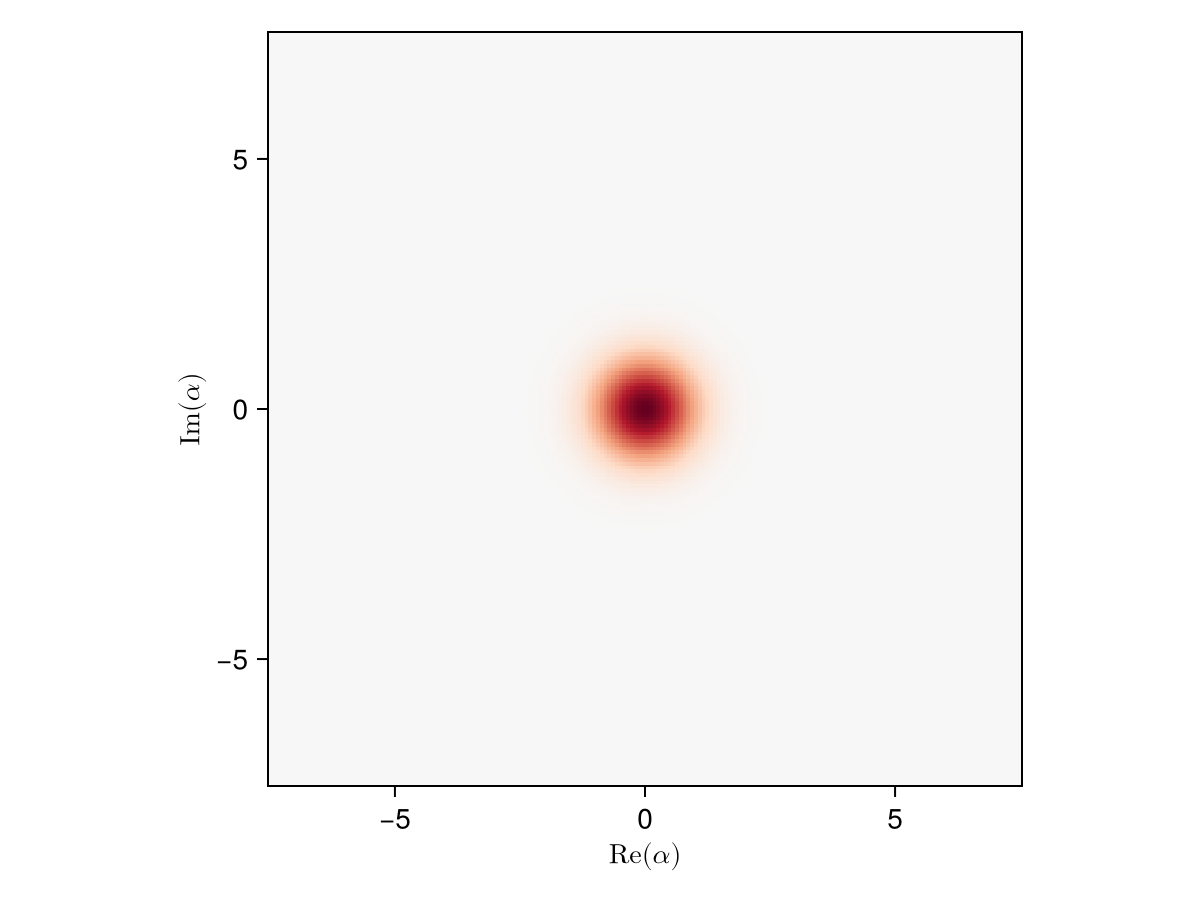

In [50]:
fig, = plot_wigner(prob.trajectory, 1)
fig

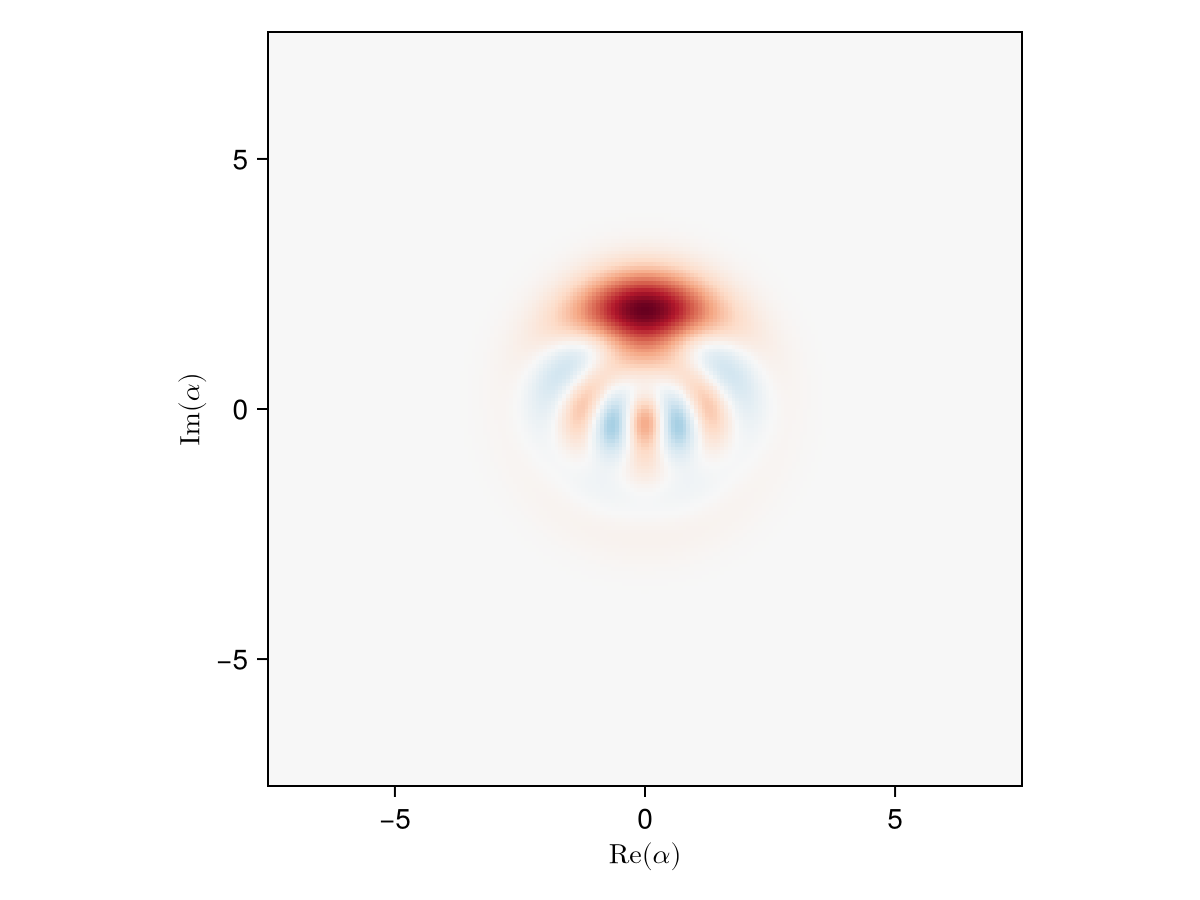

In [51]:
fig, = plot_wigner(prob.trajectory, prob.trajectory.T)
fig

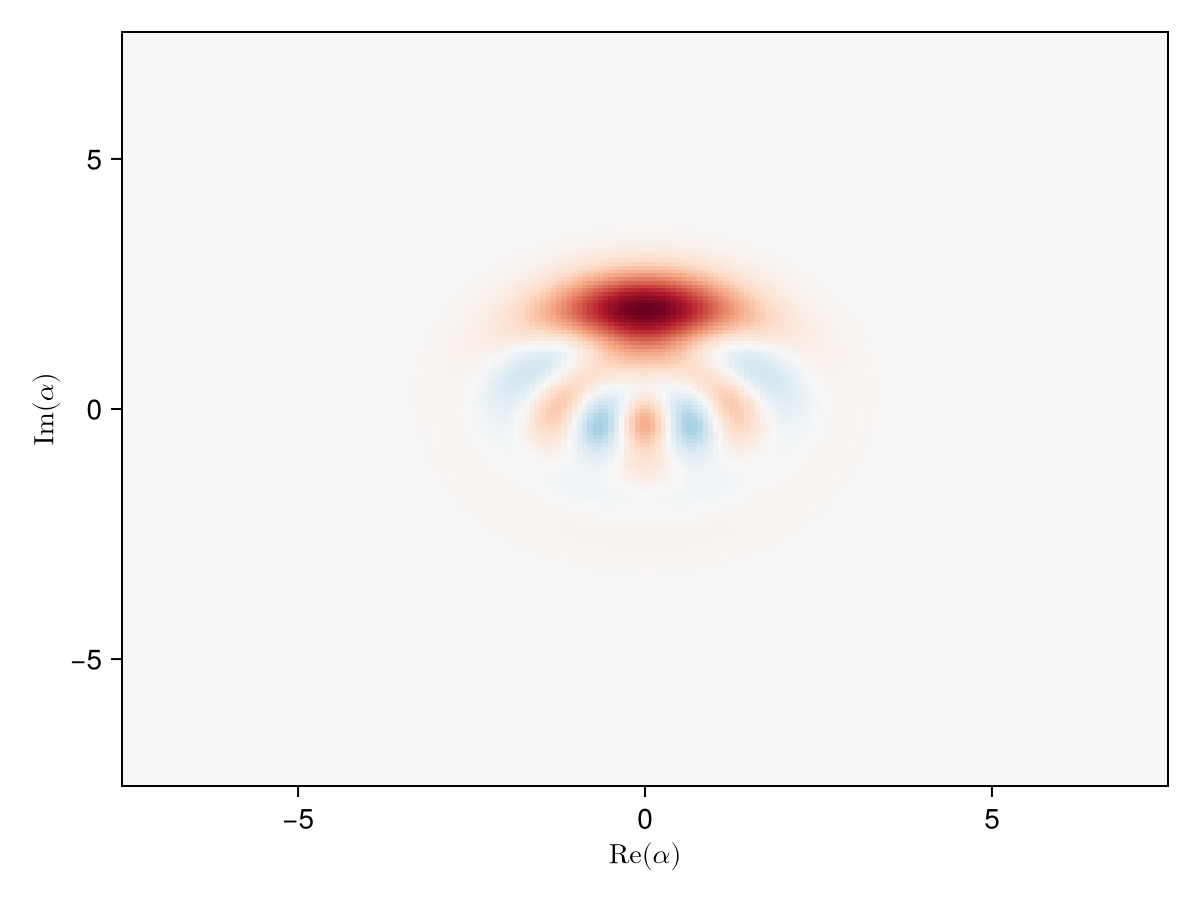

In [52]:
fig, = plot_wigner(QuantumObject(ψα))
fig

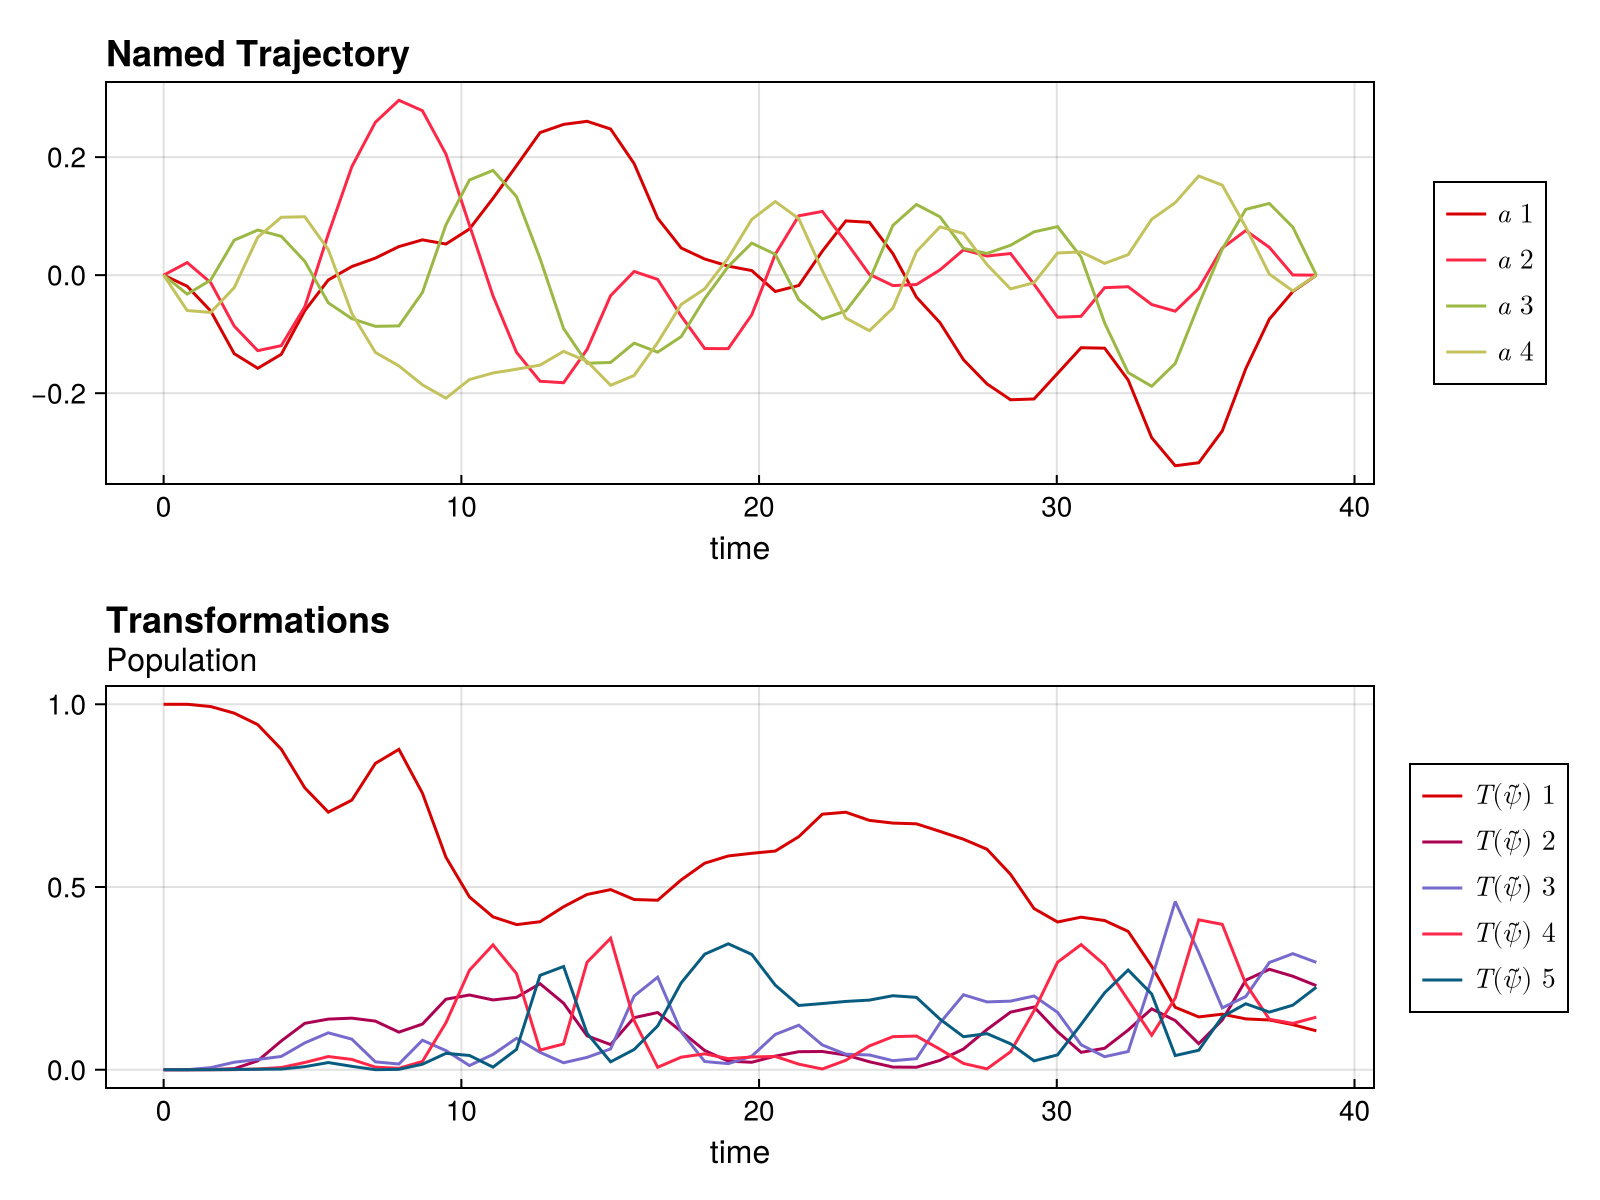

In [53]:
plot(
    prob.trajectory, [:a],
    transformations = [:ψ̃ => ψ̃ -> abs2.(iso_to_ket(ψ̃)),],
    use_autolimits=true,
    transformation_titles = ["Population"],
)

### Minimum Time

In [54]:
min_prob = QuantumStateMinimumTimeProblem(prob, ψα)

    constructing QuantumStateMinimumTimeProblem...
	final fidelity: 1.0


DirectTrajOptProblem
   timesteps            = 50
   duration             = 38.71909900101553
   variable names       = (:ψ̃, :a, :da, :dda, :Δt)
   knot point dimension = 23


In [55]:
solve!(min_prob, max_iter=100)

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of ψ̃
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:     9348
Number of nonzeros in inequality constraint Jacobian.:       10
Number of nonzeros in Lagrangian Hessian.............:     5594

Total number of variables............................:     1132
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      442
                     variables with only upper bounds:        0
Total number of equality constraints.................:      931
Total number o

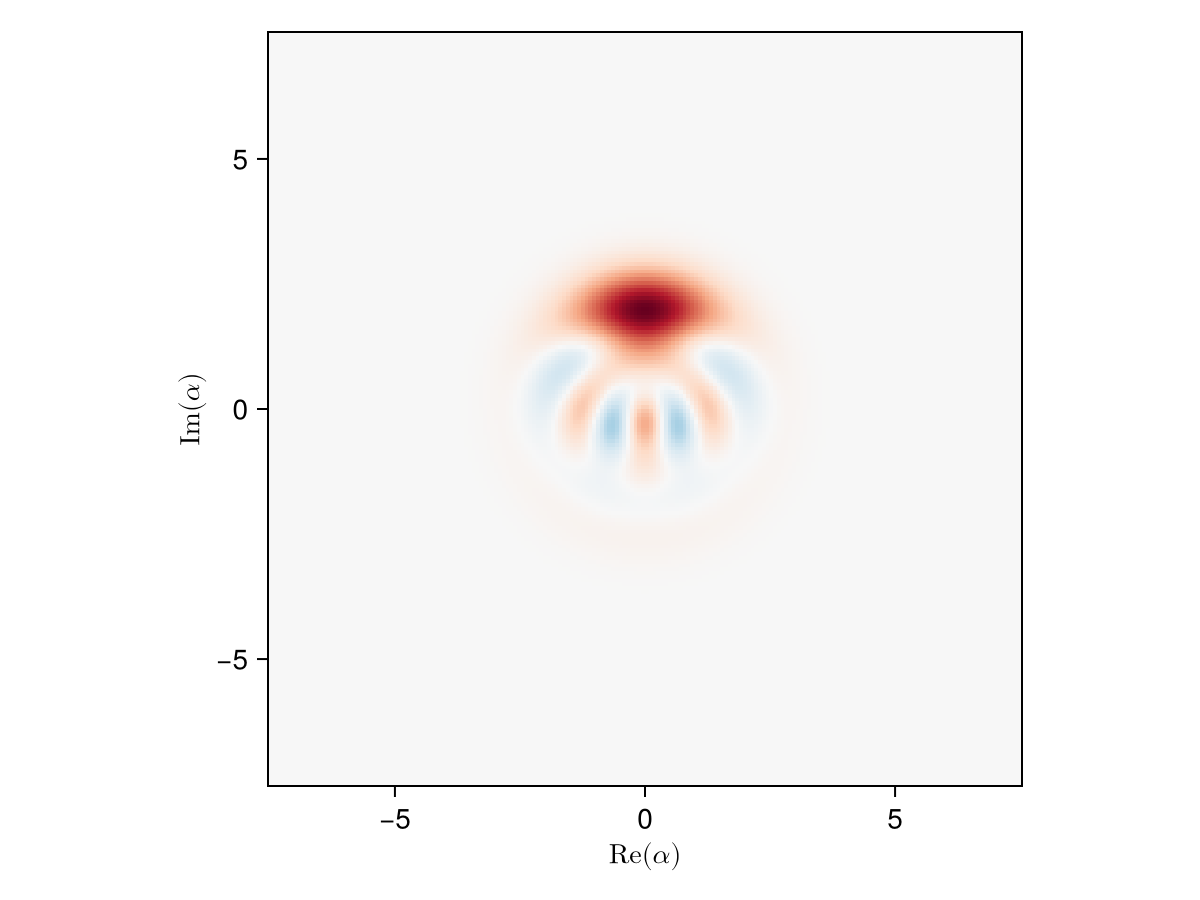

In [56]:
fig, = plot_wigner(min_prob.trajectory, min_prob.trajectory.T)
fig

In [62]:
fig, = plot_bloch(min_prob.trajectory)
fig

ArgumentError: ArgumentError: Bloch sphere visualization is only supported for qubit states (2-level systems)

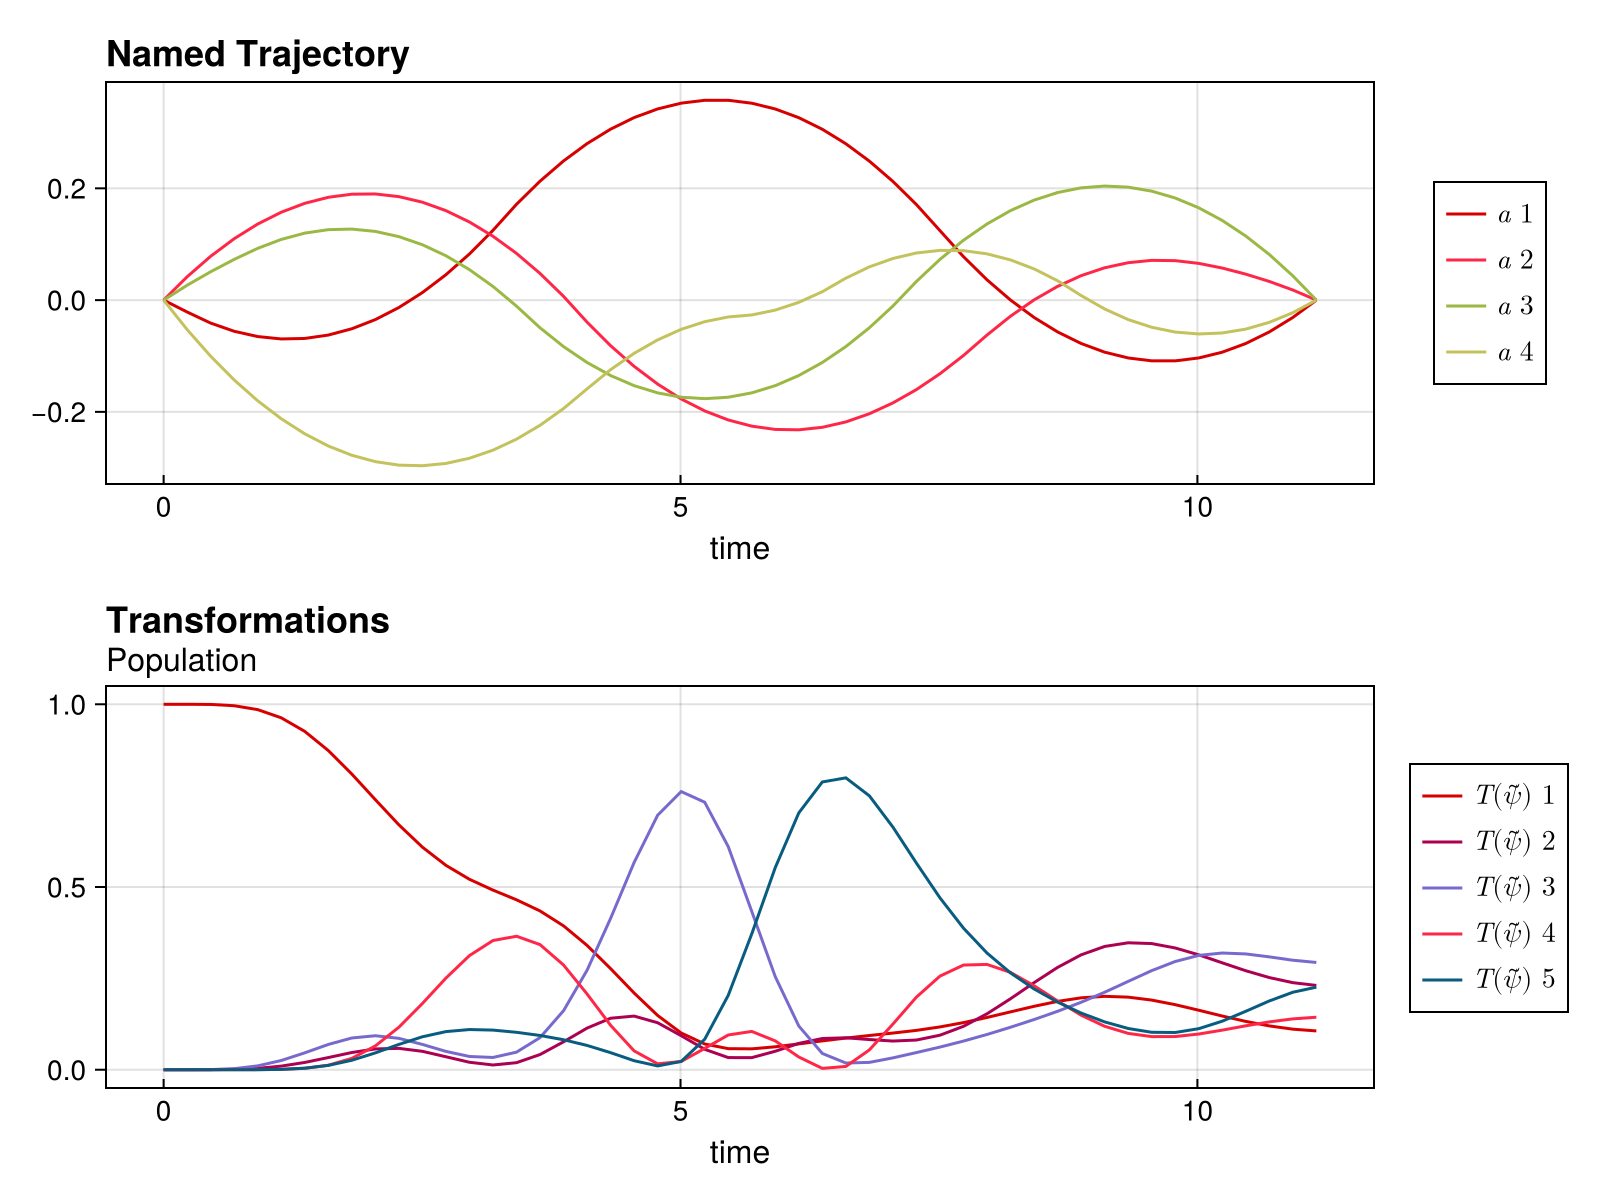

In [57]:
plot(
    min_prob.trajectory, [:a],
    transformations = [:ψ̃ => ψ̃ -> abs2.(iso_to_ket(ψ̃)),],
    use_autolimits=true,
    transformation_titles = ["Population"],
)

## Squeezed states

In [126]:
# From previous code block
# Set the system up
n_levels = 4

# Aim for a two-legged cat qubit
a = lift_operator(annihilate(n_levels), 1, n_levels);
b = lift_operator(annihilate(n_levels), 2, n_levels);


In [130]:
# a'a'*a*a
# Let's try just giving it x controls in a,b
X_a = a + a'
X_b = b + b'
Z_ab = a'b + a*b' # and Z between a and b (CZ?)

# and make some drift 
η = -0.3
# H_drift = η/2 * (a'a'*a*a + b'b'*b*b)

H_drive = [X_a,a'a',Z_ab]
# H_drive = [X_a,X_b,Z_ab]

sys = QuantumSystem(H_drive)

# Initial state
ψ0 = I(n_levels)[:, 1] .+ 0.0im

# Cat state (?)
🐱 = ψα = displacement(im * 1.5) * ψ0;
# ψs = squeezing(0.5) * displacement(0.5 + 0.5im) * ψ0;

DimensionMismatch: DimensionMismatch: second dimension of A, 256, does not match length of x, 4

In [131]:
Z_ab

256×256 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
    ⋮                             ⋱                           ⋮
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im 

In [132]:
# try to get to the state
T = 50
Δt = 0.4
cat = QuantumStateSmoothPulseProblem(sys, ψ0, 🐱, T, Δt, dda_bound=0.1)
solve!(cat, max_iter=75, options=IpoptOptions(eval_hessian=true))

    constructing QuantumStateSmoothPulseProblem...
	using integrator: typeof(KetIntegrator)
	using 1 initial state(s)
	applying timesteps_all_equal constraint: Δt


AssertionError: AssertionError: size(G(ones(u_dim))) == (x_dim, x_dim)

In [ ]:
rollout_fidelity(prob.trajectory, sys)

4×4 Matrix{ComplexF64}:
      0.0+0.0im  0.353553+0.0im  0.353553+0.0im       0.0+0.0im
 0.353553+0.0im       0.0+0.0im       0.0+0.0im  0.353553+0.0im
 0.353553+0.0im       0.0+0.0im       0.0+0.0im  0.353553+0.0im
      0.0+0.0im  0.353553+0.0im  0.353553+0.0im       0.0+0.0im

In [75]:
normalize!(X_a)

4×4 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.5+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.5+0.0im
 0.5+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.5+0.0im  0.0+0.0im  0.0+0.0im

In [ ]:

X = a + a'
Y = -im * (a - a')
X2 = a^2 + (a')^2
Y2 = -im * (a^2 - (a')^2)

Ω = 1.0
κ = 0.1

sys = QuantumSystem([X, Y, X2, Y2])

# Displacement and squeezing operators
function displacement(α)
    return exp(α * a' - conj(α) * a)
end

function squeezing(r)
    return exp((r / 2) * (a^2 - (a')^2))
end

# Initial states
ψ0 = I(n_levels)[:, 1] .+ 0.0im
ψα = displacement(im * 1.5) * ψ0;
ψs = squeezing(0.5) * displacement(0.5 + 0.5im) * ψ0;